<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#The-mulearn-module" data-toc-modified-id="The-mulearn-module-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>The <code>mulearn</code> module</a></span></li></ul></div>

# The `mulearn` module 

> The `mulearn` module contains the implementations of fuzzy inductors.

In [ ]:
#export

import numpy as np
from warnings import warn
import copy

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils import check_random_state

import mulearn.kernel as kernel
import mulearn.fuzzifier as fuzz
from mulearn.optimization import solve_optimization
from mulearn.optimization import solve_optimization_tensorflow

import logging

logger = logging.getLogger(__name__)

In [ ]:
# default_exp __init__

In [ ]:
#hide
from nbdev.showdoc import show_doc

In [ ]:
#export

class FuzzyInductor(BaseEstimator, RegressorMixin):

    def __init__(self,
                 c=1,
                 k=kernel.GaussianKernel(),
                 #sample_generator=None,
                 fuzzifier=(fuzz.ExponentialFuzzifier, {}),
                 #fuzzifier=fuzz.ExponentialFuzzifier,
                 #fuzzifier_opts = {},
                 solve_strategy=(solve_optimization_tensorflow, {}),
                 random_state=None,
                 #return_vars=False,
                 return_profile=False):
        r'''Creates an instance of `FuzzyInductor`
        
        - `c`: trade-off constant (`float`).
        
        - `k`: kernel function (`mulearn.kernel.Kernel`).
        
        - `fuzzifier`: fuzzifier mapping distance values to membership
           degrees (tuple containing a `mulearn.fuzzifiers.Fuzzifier`
           subclass F and a dictionary holding fixed parameters to be
           passed to the constructor of F).
        
        - `solve_strategy`: strategy to be used to solve optimization (tuple
           containing the reference to an optimization function and a
           dictionary holding optimization parameters).
        
        - `random_state`: seed of pseudorandom generator (`int`).
        
        - `return_profile`: flag triggering the generation of the profile of
          the learnt fuzzy set (`bool`).
        
        '''
        
        self.c = c
        self.k = k
        #self.sample_generator = sample_generator

        #self.fuzzifier = fuzzifier_descr[0]
        #self.fuzzifier_opts = fuzzifier_descr[1]
        self.solve_strategy = solve_strategy
        self.fuzzifier = fuzzifier
        self.random_state = random_state
        #self.return_vars = return_vars
        self.return_profile = return_profile
        
        
    def fix_object_state(self, X, y):
        self.X = X
        self.y = y

        def x_to_sq_dist(x_new):
            ret = self.k.compute(x_new, x_new) \
                  - 2 * np.array([self.k.compute(x_i, x_new)
                                  for x_i in X]).dot(self.chis_) \
                  + self.fixed_term_
            return ret
        self.x_to_sq_dist_ = x_to_sq_dist

        self.chi_SV_index_ = [i for i, (chi, mu) in enumerate(zip(self.chis_,
                                                                  y))
                              if -self.c * (1-mu) < chi < self.c * mu]

        #self.chi_SV_index_ = [i for i in range(len(self.chis)_) \
        #        if -self.c*(1-self.mu[i]) < self.chis_[i] < self.c*self.mu[i]]

        chi_sq_radius = map(x_to_sq_dist, X[self.chi_SV_index_])
        chi_sq_radius = list(chi_sq_radius)
        #chi_sq_radius = [x_to_sq_dist(x[i]) for i in chi_SV_index]

        if len(chi_sq_radius) == 0:
            self.estimated_membership_ = None
            self.train_error_ = np.inf
            self.chis_ = None
            self.profile = None
            logger.warn('No support vectors found')
            return self
            #raise ValueError('No support vectors found')

        self.sq_radius_ = np.mean(chi_sq_radius)
        #num_samples = 500

        #if self.sample_generator is None:
        #    self.sample_generator = lambda x: x

        #sample = map(self.sample_generator,
        #             self.random_state_.random_sample(num_samples))
        #sample = self.sample_generator(num_samples)


        fuzzifier = self.fuzzifier[0](X, y, **self.fuzzifier[1])
        result = fuzzifier.get_membership(
                self.sq_radius_, # sq_radius, was SV_square_distance_
                self.x_to_sq_dist_,
                return_profile=self.return_profile)


        if self.return_profile:
            self.estimated_membership_, self.profile_ = result
        else:
            self.estimated_membership_ = result[0]

    def fit(self, X, y, **kwargs):
        r'''Induces the membership function starting from a labeled sample
        
        - `X`: vectors in data space (iterable of `float` vectors having the
          same length).
        
        - `y`: membership for the vectors in `X` (iterable of `float` having
          the same length of `X`).
          
        Returns: self

        Throws:

        - ValueError if the values in `y` are not between 0 and 1, if `X` and
          have different lengths, or if `X` contains elements of different
          lengths.
        
        '''
        
        if type(X) is not np.array:
            X = np.array(X)
            
        for e in y:
            if e < 0 or e > 1:
                raise ValueError('`y` values should belong to [0, 1]')
        

        check_X_y(X, y)
        self.random_state_ = check_random_state(self.random_state)

        if 'warm_start' in kwargs and kwargs['warm_start']:
            check_is_fitted(self, ['chis_', 'estimated_membership_'])
            self.solve_strategy[1]['init'] = self.chis_

        self.chis_ = solve_optimization(X, y,
                                        self.c, self.k,
                                        self.solve_strategy[0],
                                        **self.solve_strategy[1])

        if type(self.k) is kernel.PrecomputedKernel:
            self.gram_ = self.k.kernel_computations
        else:
            self.gram_ = np.array([[self.k.compute(x1, x2) for x1 in X]
                                    for x2 in X])
        self.fixed_term_ = np.array(self.chis_).dot(self.gram_.dot(self.chis_))

        self.fix_object_state(X, y)

        self.train_error_ = np.mean([(self.estimated_membership_(x) - mu)**2
                                    for x, mu in zip(X, y)])

        return self


    def predict(self, X):
        r'''Computes predictions for the membership grades of one or more
        vectors.
        
        - `X`: vectors in data space (iterable of vectors having the same
          length).
          
        Returns: array of the predictions for each value in `X`.
        
        '''

        check_is_fitted(self, ['chis_', 'estimated_membership_'])
        X = check_array(X)
        return np.array([self.estimated_membership_(x) for x in X])

    def score(self, X, y):
        r'''Computes the negated accuracy of the learnt fuzzy set against
        a set of labeled data.
        
        - `X`: vectors in data space (iterable of `float` vectors having the
          same length).
          
        - `y`: membership for the vectors in `X` (iterable of `float` having
          the same length of `X`).
          
        Returns: negated accuracy of the predictions done on the elements in
        `X` w.r.t. the labels in `y`.
        
        '''
        
        check_X_y(X, y)
        
        if self.estimated_membership_ is None:
            return -np.inf
        else:
            return -np.mean([(self.estimated_membership_(x) - mu)**2
                             for x, mu in zip(X, y)])
        
    def __getstate__(self):
        d = copy.deepcopy(self.__dict__)
        del d['estimated_membership_']
        del d['x_to_sq_dist_']
        return d
        
        
    def __setstate__(self, d):
        self.__dict__ = d
        self.fix_object_state(self.X, self.y)
        self.__dict__['estimated_membership_'] = self.estimated_membership_
        self.__dict__['x_to_sq_dist_'] = self.x_to_sq_dist_
        

In [ ]:
show_doc(FuzzyInductor.__init__)

<h4 id="FuzzyInductor.__init__" class="doc_header"><code>FuzzyInductor.__init__</code><a href="__main__.py#L5" class="source_link" style="float:right">[source]</a></h4>

> <code>FuzzyInductor.__init__</code>(**`c`**=*`1`*, **`k`**=*`GaussianKernel(1)`*, **`fuzzifier`**=*`(<class 'mulearn.fuzzifier.ExponentialFuzzifier'>, {})`*, **`solve_strategy`**=*`(<function solve_optimization_tensorflow at 0x7fe1a2d9af28>, {})`*, **`random_state`**=*`None`*, **`return_profile`**=*`False`*)

Creates an instance of [`FuzzyInductor`](/mulearn/mulearn#FuzzyInductor)

- `c`: trade-off constant (`float`).

- `k`: kernel function (`mulearn.kernel.Kernel`).

- [`fuzzifier`](/mulearn/fuzzifier): fuzzifier mapping distance values to membership
   degrees (tuple containing a `mulearn.fuzzifiers.Fuzzifier`
   subclass F and a dictionary holding fixed parameters to be
   passed to the constructor of F).

- `solve_strategy`: strategy to be used to solve optimization (tuple
   containing the reference to an optimization function and a
   dictionary holding optimization parameters).

- `random_state`: seed of pseudorandom generator (`int`).

- `return_profile`: flag triggering the generation of the profile of
  the learnt fuzzy set (`bool`).

In [ ]:
xs  = [[1], [2], [3], [4], [5],  [6], [7], [8], [9]]
mus = [1,     1,  .8,  .7,  .4,   .2,   0,   0,  0]

f = FuzzyInductor()

In [ ]:
show_doc(FuzzyInductor.fit)

<h4 id="FuzzyInductor.fit" class="doc_header"><code>FuzzyInductor.fit</code><a href="__main__.py#L106" class="source_link" style="float:right">[source]</a></h4>

> <code>FuzzyInductor.fit</code>(**`X`**, **`y`**, **\*\*`kwargs`**)

Induces the membership function starting from a labeled sample

- `X`: vectors in data space (iterable of `float` vectors having the
  same length).

- `y`: membership for the vectors in `X` (iterable of `float` having
  the same length of `X`).
  
Returns: self

Throws:

- ValueError if the values in `y` are not between 0 and 1, if `X` and
  have different lengths, or if `X` contains elements of different
  lengths.

In [ ]:
predictions = f.fit(xs, mus)

100%|██████████| 100/100 [00:01<00:00, 64.80it/s]


In [ ]:
show_doc(FuzzyInductor.predict)

<h4 id="FuzzyInductor.predict" class="doc_header"><code>FuzzyInductor.predict</code><a href="__main__.py#L160" class="source_link" style="float:right">[source]</a></h4>

> <code>FuzzyInductor.predict</code>(**`X`**)

Computes predictions for the membership grades of one or more
vectors.

- `X`: vectors in data space (iterable of vectors having the same
  length).
  
Returns: array of the predictions for each value in `X`.

In [ ]:
f.predict([[0], [19]])

array([0.50000001, 0.50000002])

In [ ]:
show_doc(FuzzyInductor.score)

<h4 id="FuzzyInductor.score" class="doc_header"><code>FuzzyInductor.score</code><a href="__main__.py#L175" class="source_link" style="float:right">[source]</a></h4>

> <code>FuzzyInductor.score</code>(**`X`**, **`y`**)

Computes the negated accuracy of the learnt fuzzy set against
a set of labeled data.

- `X`: vectors in data space (iterable of `float` vectors having the
  same length).
  
- `y`: membership for the vectors in `X` (iterable of `float` having
  the same length of `X`).
  
Returns: negated accuracy of the predictions done on the elements in
`X` w.r.t. the labels in `y`.

In [ ]:
f.score(xs, mus)

-0.1644444507417577

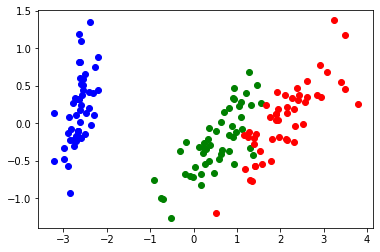

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

source = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'

iris_df = pd.read_csv(source, header=None)
iris_df.columns=['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class']

iris_values = iris_df.iloc[:,0:4].values
iris_labels = iris_df.iloc[:,4].values

pca_2d = PCA(n_components=2)
iris_values_2d = pca_2d.fit_transform(iris_values)

def gr_dataset(): 
    for lab, col in zip(('Iris-setosa', 'Iris-versicolor', 'Iris-virginica'),
                        ('blue', 'green', 'red')):
        plt.scatter(iris_values_2d[iris_labels==lab, 0],
                    iris_values_2d[iris_labels==lab, 1],
                    label=lab,
                    c=col)

gr_dataset()

In [ ]:
def to_membership_values(labels, target):
    return [1 if l==target else 0 for l in labels]

mu = {}
for target in ('Iris-setosa', 'Iris-versicolor', 'Iris-virginica'):
    mu[target] = to_membership_values(iris_labels, target)

In [ ]:
def gr_membership_contour(estimated_membership):
    x = np.linspace(-4, 4, 50)
    y = np.linspace(-4, 4, 50)
    X, Y = np.meshgrid(x, y)
    zs = np.array([estimated_membership((x, y))
                   for x,y in zip(np.ravel(X), np.ravel(Y))])
    Z = zs.reshape(X.shape)
    membership_contour = plt.contour(X, Y, Z,
                                     levels=(.1, .3, .5, .95), colors='k')
    plt.clabel(membership_contour, inline=1)

In [ ]:
f = FuzzyInductor()
f.fit(iris_values_2d, mu['Iris-virginica'])

100%|██████████| 100/100 [00:18<00:00,  5.52it/s]


FuzzyInductor()

In [ ]:
from mulearn.kernel import GaussianKernel

sigmas = [.225,.5]
parameters =  {'c':[1],
               'k':[GaussianKernel(i) for i in sigmas]}

In [ ]:


f = FuzzyInductor(solve_strategy=(solve_optimization_tensorflow, {'tracker': range}))

In [ ]:
from sklearn.model_selection import GridSearchCV

virginica = GridSearchCV(f, param_grid=parameters, cv=2)
#virginica.fit(iris_values_2d, mu['Iris-virginica'])
virginica.fit(xs, mus)

fitting 1, GaussianKernel(0.225), (<class 'mulearn.fuzzifier.ExponentialFuzzifier'>, {})
fitting 1, GaussianKernel(0.225), (<class 'mulearn.fuzzifier.ExponentialFuzzifier'>, {})
fitting 1, GaussianKernel(0.5), (<class 'mulearn.fuzzifier.ExponentialFuzzifier'>, {})
fitting 1, GaussianKernel(0.5), (<class 'mulearn.fuzzifier.ExponentialFuzzifier'>, {})
fitting 1, GaussianKernel(0.225), (<class 'mulearn.fuzzifier.ExponentialFuzzifier'>, {})


GridSearchCV(cv=2, error_score=nan,
             estimator=FuzzyInductor(c=1,
                                     fuzzifier=(<class 'mulearn.fuzzifier.ExponentialFuzzifier'>,
                                                {}),
                                     k=GaussianKernel(1), random_state=None,
                                     return_profile=False,
                                     solve_strategy=(<function solve_optimization_tensorflow at 0x7ff794b94378>,
                                                     {'tracker': <class 'range'>})),
             iid='deprecated', n_jobs=None,
             param_grid={'c': [1],
                         'k': [GaussianKernel(0.225), GaussianKernel(0.5)]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
virginica.best_params_

{'c': 1, 'k': GaussianKernel(0.225)}

In [ ]:
virginica.best_score_

nan

In [ ]:
virginica.best_estimator_

FuzzyInductor(c=1,
              fuzzifier=(<class 'mulearn.fuzzifier.ExponentialFuzzifier'>, {}),
              k=GaussianKernel(0.225), random_state=None, return_profile=False,
              solve_strategy=(<function solve_optimization_tensorflow at 0x7ff794b94378>,
                              {'tracker': <class 'range'>}))